In [12]:
# Don't forget to restart
# !pip install -U tensorflow_probability -q
# !pip install ipdb tensorflow==2.5.0 -q
# !pip install ipdb -q
# !pip install git+https://github.com/tensorflow/docs -q
!pip install -U -i https://test.pypi.org/simple/ nsc -q

# Imports

In [13]:
# -*- coding: utf-8 -*-
'''
Created on Fri Oct 22 00:41:39 2021

@author: jkcle
'''

from IPython import display

import math
import glob
import imageio
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from pathlib import Path
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import time
from datetime import datetime
import os
import random
from tqdm import tqdm
from collections import defaultdict
from sklearn.manifold import TSNE

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Input, InputLayer, Lambda, Reshape, \
                                    Dropout, Flatten, Dense, Conv2D, \
                                    Conv2DTranspose

import nsc_tf
from math import pi

from tensorflow import repeat, squeeze, reduce_mean, matmul, expand_dims, \
                       transpose, reduce_prod, pow, square, sqrt, cast, \
                       where, zeros_like, int32, float32, equal, reduce_all 
from tensorflow.random import set_seed
from tensorflow.math import log, lgamma, exp, is_finite, reduce_sum, \
                            count_nonzero, add, subtract, multiply, divide
from tensorflow.linalg import det, diag_part, inv, trace

# Additonal Setup

In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Class and Function Definitions

## Generalized Mean Function

In [15]:
def kappa_to_r(kappa, dim=1):
  return -2*kappa / (1 + dim*kappa)

In [16]:
def generalized_mean(values: tf.Tensor, r: float = 1.0, weights: tf.Tensor= None) -> tf.Tensor:
    """
    This function calculates the generalized mean of a 1-D array of non- 
    negative real numbers using the coupled logarithm and exponential functions.
    
    Parameters
    ----------
    values : np.ndarray
        A 1-D numpy array (row vector) of non-negative numbers for which we are
        calculating the generalized mean.
    r : float, optional
        The risk bias and the power of the generalized mean. The default is 1.0 
        (Arithmetric Mean).
    weights : np.ndarray, optional
        A 1-D numpy array of the weights for each value. Default is None 
        (which triggers a conditional to use equal weights).
    Returns
    -------
    gen_mean : float
        The coupled generalized mean.
    """
            
    # If weights equals None, equally weight all observations.
    if type(weights) == type(None):
        weights = tf.ones(values.shape)
    
    # Calculate the log of the generalized mean by taking the dot product of the
    # weights vector and the vector of the coupled logarithm of the values and
    # divide the result by the sum of the the weights.
    if len(values.shape) > 1:
        log_gen_mean = (np.dot(weights, tf.transpose(nsc_tf.log(values, kappa=r, dim=0)))
                        / tf.reduce_sum(weights, axis=1))
        log_gen_mean = log_gen_mean[0]
    else:
        log_gen_mean = (np.dot(weights, nsc_tf.log(values, kappa=r, dim=0)) 
                        / tf.reduce_sum(weights))
        
    # Calculate the generalized mean by exponentiating the log-generalized mean.
    gen_mean = nsc_tf.exp(log_gen_mean, kappa=r, dim=0)
    
    # Return the generalized mean.
    return gen_mean

In [17]:
def generalized_mean(values, r):
    if r != 0:
      gen_mean = tf.pow(tf.reduce_mean(tf.pow(np.array(values), r)), (1/r))
    else:
      gen_mean = tf.exp(tf.reduce_mean(tf.math.log(values)))
    return gen_mean

## Set-Up Functions

In [18]:
def update_experiments(experiment_params_dict, file_path):
  '''Update the CSV file that is tracking experimental parameters or make it
  if it does not exist.

  Inputs
  ------
  experiment_params_dict : dict
    A dictionary containing experimental parameters.
  file_path : str
    A path to the file tracking experimental parameters.

  Returns
  -------
  None

  '''

  # Covert the experiment_params_dict to a dataframe.
  experiment_params_df = pd.DataFrame(
      experiment_params_dict.items()
      ).set_index(0).T
  # If the file exists.
  if Path(file_path).exists():
    # Let the know the user know the file exists.
    print(f'Reading [{file_path}]')
    # Read in the file.
    old_experiments = pd.read_csv(file_path)
    # Let the user know the file is being updated.
    print(f'Updating [{file_path}]')
    # Add the new experimantal data to the old.
    experiment_params_df = pd.concat([old_experiments, experiment_params_df])
  # Let the user know the file is being written.
  print(f'Writing [{file_path}]')
  # Write the experimental params to the CSV.
  experiment_params_df.to_csv(file_path, index=False)

  return


def create_gdrive_output_folders(save_path, 
                                 img_folders=['identity', 
                                              'motion_blur', 
                                              'rotate', 
                                              'translate'], # The first is the training dataset.
                                 viz_folders=['generated_images', 
                                              'latent_spaces', 
                                              'manifolds', 
                                              'histograms',
                                              'metrics']
                                 ):
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    train_img_path = save_path / 'train' / f'{img_folders[0]}'
    train_img_path.mkdir(parents=True, exist_ok=True)

    for viz_folder in viz_folders:
      viz_path = train_img_path / f'{viz_folder}'
      viz_path.mkdir(parents=True, exist_ok=True)
      if viz_folder == 'histograms':
        temp_path = viz_path / 'elbo'
        temp_path.mkdir(parents=True, exist_ok=True)
        temp_path = viz_path / 'recon'
        temp_path.mkdir(parents=True, exist_ok=True)
        temp_path = viz_path / 'kldiv/'
        temp_path.mkdir(parents=True, exist_ok=True)

    # Changed 8_26_2021: added explicit testing on each directory
    for img_folder in img_folders:
      img_path = save_path / 'test' / f'{img_folder}'
      img_path.mkdir(parents=True, exist_ok=True)
      for viz_folder in viz_folders:
        viz_path = img_path / f'{viz_folder}'
        viz_path.mkdir(parents=True, exist_ok=True)
        if viz_folder == 'histograms':
          temp_path = viz_path / 'elbo'
          temp_path.mkdir(parents=True, exist_ok=True)
          temp_path = viz_path / 'recon'
          temp_path.mkdir(parents=True, exist_ok=True)
          temp_path = viz_path / 'kldiv/'
          temp_path.mkdir(parents=True, exist_ok=True)

    return


def check_gpu_availibility():
  '''This function checks if a GPU is present in a Google Colab notebook.
  '''

  # Import gpu_device_name from tensorflow.test.
  from tensorflow.test import gpu_device_name
  # If a GPU device is not detected, notify the user.
  if gpu_device_name() != '/device:GPU:0':
      print('WARNING: GPU device not found.')
  # If a GPU is detected, notify the user.
  else:
      print(f'SUCCESS: Found GPU: {gpu_device_name()}')
  return


def _preprocess(sample):
    '''Cast all the pixel values in a sample to 64-bit float and scale them
    between 0 and 1.
    '''
    image = tf.cast(sample['image'], tf.float64) / 255.
    return image


def _preprocess_label(sample):
    '''Cast the label of a sample to 64-bit integer.
    '''
    label = tf.cast(sample['label'], tf.int64)
    return label


def get_datasets(datasets_names, 
                 batch_size_train, 
                 batch_size_test, 
                 mnist_split,
                 random_seed
                 ):
    datasets = defaultdict(dict)
    for datasets_name in datasets_names:
        print('============================================================')
        print(f'\nExtracting {datasets_name.upper()} dataset...\n')
        # # CW - *** modified code such that when MNIST is loaded it gets 
        # # automatically split into train and validation sets
        if datasets_name == 'mnist':
          (mtrain, mvalidation, mtest), datasets_raw_info = tfds.load(
              name=datasets_name,
              with_info=True,
              as_supervised=False,
              split=[
                  'train[:'+mnist_split+']', 
                  'train['+mnist_split+':]', 
                  'test']
              )
          
          train_size = int(mnist_split)
          datasets[datasets_name]['train'] = (
              mtrain.map(_preprocess)
              .batch(batch_size_train)
              .prefetch(tf.data.experimental.AUTOTUNE)
              .shuffle(train_size, seed=random_seed)
              )
          
          datasets[datasets_name]['val'] = (
              mvalidation
              .map(_preprocess)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
          datasets[datasets_name]['val_label'] = (
              mvalidation
              .map(_preprocess_label)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
          datasets[datasets_name]['test'] = (
              mtest
              .map(_preprocess)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
          datasets[datasets_name]['test_label'] = (
              mtest
              .map(_preprocess_label)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
        else:
          datasets_raw, datasets_raw_info = tfds.load(
              name=datasets_name,
              with_info=True,
              as_supervised=False
              )
          datasets[datasets_name]['test'] = (
              datasets_raw['test']
              .map(_preprocess)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
          datasets[datasets_name]['test_label'] = (
              datasets_raw['test']
              .map(_preprocess_label)
              .batch(batch_size_test)
              .prefetch(tf.data.experimental.AUTOTUNE)
              )
        print(datasets_raw_info)

        print('Here')
        if 'corrupted' in datasets_name:
          # View some examples from the dataset
          fig, axes = plt.subplots(3, 3, figsize=(8, 8))
          fig.subplots_adjust(hspace=0.2, wspace=0.1)
          for i, (elem, ax) in enumerate(
                  zip(datasets_raw['train'], axes.flat)
                  ):
              image = tf.squeeze(elem['image'])
              # print(image)
              label = elem['label']

              ax.imshow(image, cmap='gray')
              ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
                      transform=ax.transAxes, color='black')
              ax.set_xticks([])
              ax.set_yticks([])
              # plt.show()
        else:
          # View some examples from the dataset
          fig, axes = plt.subplots(3, 3, figsize=(8, 8))
          fig.subplots_adjust(hspace=0.2, wspace=0.1)
          for i, (elem, ax) in enumerate(zip(mtrain, axes.flat)):
              image = tf.squeeze(elem['image'])
              # print(image)
              label = elem['label']

              ax.imshow(image, cmap='gray')
              ax.text(0.7, -0.12, f'Digit = {label}', ha='right',
                      transform=ax.transAxes, color='black')
              ax.set_xticks([])
              ax.set_yticks([])
              # plt.show()

        if 'corrupted' not in datasets_name:
            #
            print(' - Print one train set image:')
            for train_batch in datasets[datasets_name]['train'].take(1):
                image = train_batch[0].numpy()
            image = np.squeeze(image)
            plt.figure()
            plt.imshow(image, cmap='gray')
            plt.colorbar()
            plt.grid(False)
            plt.axis('off')
            plt.show();

        #
        print(' - Print one test set image:')
        for test_batch in datasets[datasets_name]['test'].take(1):
            image = test_batch[0].numpy()
        image = np.squeeze(image)
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.colorbar()
        plt.grid(False)
        plt.axis('off')
        plt.show();

        #
        print(' - Print one test set label:')
        for test_label in datasets[datasets_name]['test_label'].take(1):
            label = test_label[0]
        print(label.numpy())
        print('\n')

    return datasets

## Sampler

In [19]:
class Sampler_Z(tfkl.Layer):   

    def call(self, inputs):
        mean, logvar = inputs
        # Reparameterize
        eps = tf.random.normal(shape=mean.shape, seed=0)
        z_sample = eps * tf.exp(logvar * .5) + mean
        #tf.print(tf.math.reduce_mean(eps))
        return z_sample




## Encoder

In [20]:
# Encoder/Decoder layers 1 (for MNIST images)
class EncoderZ_1(tfkl.Layer):

    def __init__(self, 
                 z_dim, 
                 n_filter_base, 
                 seed, 
                 dtype, 
                 name='encoder', 
                 **kwargs
                 ):
        super(EncoderZ_1, self).__init__(name=name, **kwargs)
        # Block-1
        self.conv_layer_1 = tfkl.Conv2D(
            filters=n_filter_base, 
            kernel_size=3,
            strides=1, 
            padding='same', 
            name='conv_1',
            dtype=dtype
            )

        self.batch_layer_1 = tfkl.BatchNormalization(
            name='bn_1', 
            dtype=dtype
            )
        self.activation_layer_1 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_1', 
            dtype=dtype
            )
        # Block-2
        self.conv_layer_2 = tfkl.Conv2D(
            filters=n_filter_base*2, 
            kernel_size=3,
            strides=2, 
            padding='same', 
            name='conv_2', 
            dtype=dtype
            )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2', dtype=dtype)
        self.activation_layer_2 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_2', 
            dtype=dtype
            )
        # Block-3
        self.conv_layer_3 = tfkl.Conv2D(
            filters=n_filter_base*2, 
            kernel_size=3,
            strides=2, 
            padding='same', 
            name='conv_3', 
            dtype=dtype
            )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3', dtype=dtype)
        self.activation_layer_3 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_3', 
            dtype=dtype
            )
        # Block-4
        self.conv_layer_4 = tfkl.Conv2D(
            filters=n_filter_base*2, 
            kernel_size=3,
            strides=1, 
            padding='same', 
            name='conv_4', 
            dtype=dtype
            )
        self.batch_layer_4 = tfkl.BatchNormalization(name='bn_4', dtype=dtype)
        self.activation_layer_4 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_4', 
            dtype=dtype
            )
        # Final Block
        self.flatten_layer = Flatten()
        self.dense_mean = Dense(
            z_dim, 
            activation=None, 
            name='z_mean', 
            dtype=dtype
            )
        self.dense_raw_stddev = Dense(
            z_dim, 
            activation=None,
            name='z_raw_stddev', 
            dtype=dtype
            )
        self.sampler_z = Sampler_Z()

    # Functional
    def call(self, x_input):
        z = self.conv_layer_1(x_input)
        z = self.batch_layer_1(z)
        z = self.activation_layer_1(z)
        z = self.conv_layer_2(z)
        z = self.batch_layer_2(z)
        z = self.activation_layer_2(z)
        z = self.conv_layer_3(z)
        z = self.batch_layer_3(z)
        z = self.activation_layer_3(z)
        z = self.conv_layer_4(z)
        z = self.batch_layer_4(z)
        z = self.activation_layer_4(z)
        z = self.flatten_layer(z)
        mean = self.dense_mean(z)
        logvar = self.dense_raw_stddev(z)
        z_sample = self.sampler_z((mean, logvar))
        return z_sample, mean, logvar

## Decoder

In [21]:
class DecoderX_1(tfkl.Layer):

    def __init__(self, z_dim, n_filter_base, dtype, name='decoder', **kwargs):
        super(DecoderX_1, self).__init__(name=name, **kwargs)
        # For MNIST images
        self.dense_z_input = tfkl.Dense(
            units=7*7*n_filter_base*2,
            activation=tf.nn.relu, 
            dtype=dtype
            )
        self.reshape_layer = tfkl.Reshape(target_shape=(7, 7, n_filter_base*2))
        # Block-1
        self.conv_transpose_layer_1 = Conv2DTranspose(
            filters=n_filter_base*2,
            kernel_size=3,
            strides=1, 
            padding='same',
            name='conv_transpose_1', 
            dtype=dtype
            )
        self.batch_layer_1 = tfkl.BatchNormalization(name='bn_1', dtype=dtype)
        self.activation_layer_1 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_1', 
            dtype=dtype
            )
        # Block-2
        self.conv_transpose_layer_2 = Conv2DTranspose(
            filters=n_filter_base*2,
            kernel_size=3,
            strides=2, 
            padding='same',
            name='conv_transpose_2', 
            dtype=dtype
            )
        self.batch_layer_2 = tfkl.BatchNormalization(name='bn_2', dtype=dtype)
        self.activation_layer_2 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_2', 
            dtype=dtype
            )
        # Block-3
        self.conv_transpose_layer_3 = Conv2DTranspose(
            filters=n_filter_base,
            kernel_size=3,
            strides=2, 
            padding='same',
            name='conv_transpose_3', 
            dtype=dtype
            )
        self.batch_layer_3 = tfkl.BatchNormalization(name='bn_3', dtype=dtype)
        self.activation_layer_3 = tfkl.Activation(
            tf.nn.leaky_relu, 
            name='lrelu_3', 
            dtype=dtype
            )
        # Block-4
        # Filters=1 for gray-scaled images
        self.conv_transpose_layer_4 = Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=1, 
            padding='same',
            name='conv_transpose_4',
            dtype=dtype
            )

    # Functional
    def call(self, z):
        x_output = self.dense_z_input(z)
        x_output = self.reshape_layer(x_output)
        x_output = self.conv_transpose_layer_1(x_output)
        x_output = self.batch_layer_1(x_output)
        x_output = self.activation_layer_1(x_output)
        x_output = self.conv_transpose_layer_2(x_output)
        x_output = self.batch_layer_2(x_output)
        x_output = self.activation_layer_2(x_output)
        x_output = self.conv_transpose_layer_3(x_output)
        x_output = self.batch_layer_3(x_output)
        x_output = self.activation_layer_3(x_output)
        x_output = self.conv_transpose_layer_4(x_output)
        return x_output

## Base Model

In [22]:
class VAEModel(tfk.Model):
    '''Convolutional variational autoencoder base model.
    '''
    
    def __init__(self, z_dim, n_filter_base, seed, dtype):
        super(VAEModel, self).__init__()
        self.encoder = EncoderZ_1(z_dim, n_filter_base, seed, dtype)
        self.decoder = DecoderX_1(z_dim, n_filter_base, dtype)
        return
    
    #@tf.function
    def sample(self, z_sample):
        x_recons_logits = self.decoder(z_sample)
        sample_images = tf.sigmoid(x_recons_logits)  # predictions
        return sample_images
    
    def call(self, x_input):
        z_sample, mean, logvar = self.encoder(x_input)
        x_recons_logits = self.decoder(z_sample)
        return x_recons_logits, z_sample, mean, logvar

## GeneralizedMean

In [23]:
class GeneralizedMean:

    def __init__(self, ll_values, kl_values, kappa, z_dim):
        self.kappa = kappa
        self.z_dim = z_dim
        self.gmean_metrics = pd.Series()
        self.gmean_log_prob_values = {}
        self._save_generalized_mean_metrics('elbo', ll_values - kl_values)
        self._save_generalized_mean_metrics('recon', ll_values)
        self._save_generalized_mean_metrics('kldiv', -kl_values)
        return
    
    def _save_generalized_mean_metrics(self, key, log_prob_values):
        # Save the generalized means and metric values
        prob_values = tf.exp(log_prob_values)
        self.inv_n = 1 / len(prob_values)  # 1/n
        decisiveness = self._calculate_decisiveness(prob_values)
        accuracy = self._calculate_accuracy(prob_values)
        robustness = self._calculate_robustness(prob_values)
        r = kappa_to_r(float(self.kappa), dim=1)  # TODO USE Z-DIM?
        gen_mean = generalized_mean(prob_values, r)
        curr_metrics = pd.Series(
            [decisiveness, accuracy, robustness, gen_mean.numpy()],
            index=[
                f'{key}_decisiveness', f'{key}_accuracy', f'{key}_robustness',
                f'{key}_{round(r, 3)}_generalized_mean'
                ]
            )
        self.gmean_metrics = self.gmean_metrics.append(curr_metrics)
        self.gmean_log_prob_values[key] = log_prob_values
    
    def _calculate_decisiveness(self, values):
        # Decisiveness = Arithmetic mean
        result = tf.reduce_sum(values) * self.inv_n
        return result.numpy()
    
    def _calculate_accuracy(self, values):
        # Accuracy = Geometric mean
        result = tf.reduce_prod(values ** self.inv_n)
        return result.numpy()
    
    def _calculate_robustness(self, values):
        # Robustness = -2/3 Mean
        result = tf.reduce_sum(values ** (-2/3))
        result = (result * self.inv_n) ** (-3/2)
        return result.numpy()
    
    def get_metrics(self):
        return self.gmean_metrics
    
    def get_log_prob_values(self):
        return self.gmean_log_prob_values

## Visualize

In [24]:
class Visualize:

    def __init__(self,
                 z_dim,
                 kappa,
                 sample_func, 
                 z_sample,
                 sample,
                 sample_labels, 
                 gmean_metrics,
                 gmean_log_prob_values, 
                 display_path='.', 
                 parameter_str=''
                 ):
        self.z_dim = z_dim
        self.kappa = kappa
        self.sample_func = sample_func
        self.z_sample = z_sample
        self.sample_labels = sample_labels
        self.gmean_metrics = gmean_metrics
        self.gmean_log_prob_values = gmean_log_prob_values
        self.display_path = display_path
        self.parameter_str = parameter_str
        if len(z_sample) <= 16:
            sample_images = sample_func(z_sample)  # predictions
            sample_images_orig = sample
        else:
            sample_images = sample_func(z_sample)[:16]  # first 16 predictions
            sample_images_orig = sample[:16]

        self.sample_images = sample_images
        self.sample_images_orig = sample_images_orig
        self.digit_size = len(sample_images[0])
        return
    
    def display(self, show=True, **kwargs):
        self.display_generated_images(show=show, **kwargs)
        self.display_original_images(show=show, **kwargs)
        self.display_latent_space(show=show, **kwargs)
        #self.display_manifold(show=show, **kwargs)
        self.display_histogram(key='recon', show=show, **kwargs)
        self.display_histogram(key='kldiv', show=show, **kwargs)
        self.display_histogram(key='elbo', show=show, **kwargs)
        return


    def display_test(self, show=True, **kwargs):
        self.display_generated_images(show=show, **kwargs)
        self.display_original_images(show=show, **kwargs)
        self.display_latent_space(show=show, **kwargs)
        #self.display_manifold(show=show, **kwargs)
        
        self.display_histogram(key='recon', show=show, **kwargs)
        self.display_histogram(key='kldiv', show=show, **kwargs)
        self.display_histogram(key='elbo', show=show, **kwargs)
        
        return
    
    def display_generated_images(self, image_size=4, show=True, **kwargs):

        fig = plt.figure(figsize=(image_size, image_size))
        for i in range(self.sample_images.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(self.sample_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
            # tight_layout minimizes the overlap between 2 sub-plots
            plt.axis('Off')
            plt.savefig(f"{self.display_path}/generated_images/" + \
                       f"{self._picture_name('images', **kwargs)}"
                    )
        if show:
            plt.show();
        return


    def display_original_images(self, image_size=4, show=True, **kwargs):

        fig = plt.figure(figsize=(image_size, image_size))
        for i in range(self.sample_images_orig.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(self.sample_images_orig[i, :, :, 0], cmap='gray')
            plt.axis('off')
            # tight_layout minimizes the overlap between 2 sub-plots
            plt.axis('Off')
            plt.savefig(f"{self.display_path}/generated_images/" + \
                       f"{self._picture_name('original_images', **kwargs)}"
                    )
        if show:
            plt.show();
        return
    
    def display_latent_space(self, image_size=4, show=True, **kwargs):
        # display a 2D plot of the digit classes in the latent space
        
        colors = ['pink', 'red', 'orange', 'yellow', 'green', 
        'blue', 'purple', 'brown', 'gray', 'black']
        plt.figure(figsize=(image_size, image_size))
        z_dim = self.z_dim
        if z_dim==2:
            plt.scatter(
                self.z_sample[:, 0], 
                self.z_sample[:, 1], 
                c=self.sample_labels,
                cmap=matplotlib.colors.ListedColormap(colors)
                )
            plt.xlabel('z[0]')
            plt.ylabel('z[1]')
        
        else:
            encoded_imgs_embedded = TSNE(n_components=2).fit_transform(
                self.z_sample
                )
            plt.scatter(
                encoded_imgs_embedded[:,0],
                encoded_imgs_embedded[:,1],
                c=self.sample_labels,
                cmap=matplotlib.colors.ListedColormap(colors)
                )
            plt.xlabel("t-SNE 1st dimension")
            plt.ylabel("t-SNE 2nd dimension")
              
            plt.colorbar()
            plt.savefig(f"{self.display_path}/latent_spaces/" + \
                        f"{self._picture_name('latent', **kwargs)}"
                        )
        if show:
            plt.show();
        return
    
    def display_manifold(self, n=20, image_size=10, show=True, **kwargs):
        """Plots n x n digit images decoded from the latent space."""
        norm = tfp.distributions.Normal(0, 1)
        grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
        grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
        image_width = self.digit_size*n
        image_height = image_width
        image = np.zeros((image_height, image_width))
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = np.array([[xi, yi]])
                x_decoded = self.sample_func(z)
                digit = tf.reshape(
                    x_decoded[0], 
                    (self.digit_size, self.digit_size)
                    )
                image[i*self.digit_size: (i+1)*self.digit_size,
                      j*self.digit_size: (j+1)*self.digit_size] = digit.numpy()
        plt.figure(figsize=(image_size, image_size))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('Off')
        plt.savefig(f"{self.display_path}/manifolds/" + \
        f"{self._picture_name('mani', **kwargs)}"
        )
        if show:
            plt.show();
        return

    def display_histogram(self, key, image_size=(24, 10), show=True, **kwargs):
        # Get histogram title and x-axis
        if key == 'recon':
            # xlabel = 'Probability of reconstructed image equivalent to original 
            # one.'
            xlabel = 'Reconstruction Probability'
            xticks = [
                1e-240, 1e-210, 1e-180, 1e-150, 1e-120, 1e-90, 1e-60, 1e-30, 1
                ]
        elif key == 'kldiv':
            xlabel = 'Divergence Probability'
            xticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
        else:
            xlabel = 'ELBO Probability'
            xticks = [
                1e-240, 1e-210, 1e-180, 1e-150, 1e-120, 1e-90, 1e-60, 1e-30, 1
                ]
        # Retrieve the generalized means and metric values
        decisiveness = self.gmean_metrics[f'{key}_decisiveness']
        accuracy = self.gmean_metrics[f'{key}_accuracy']
        robustness = self.gmean_metrics[f'{key}_robustness']
        r = kappa_to_r(float(self.kappa), dim=1)  # TODO USE Z-DIM?
        r = round(r, 3)
        r_gen_mean = self.gmean_metrics[f'{key}_{r}_generalized_mean']
        log_prob_values = self.gmean_log_prob_values[key]
        # The histogram of the data
        fig, ax = plt.subplots(figsize=(24, 10))
        xtick_axis = [math.log(xtick) for xtick in xticks]
        xtick_labels = [str(xtick) for xtick in xticks]
        ax.set_xticks(xtick_axis)
        ax.set_xticklabels(xtick_labels)
        if kwargs['epoch'] != '':
          plt.title(
              f"{xlabel} Histogram for VAE (Epoch={kwargs['epoch']})", 
              fontdict = {'fontsize' : 40, 'weight': 'bold'}
              )
        else:
          plt.title(
              f"{xlabel} Histogram for VAE", 
              fontdict = {'fontsize' : 40, 'weight': 'bold'}
              )
        plt.xlabel(xlabel, fontdict = {'fontsize' : 40, 'weight': 'bold'})
        plt.ylabel(
            "Frequency in logscale", 
            fontdict = {'fontsize' : 40, 'weight': 'bold'}
            )
        # Plot in logscale, so convert the metric as logs as well
        log_dec = np.log(decisiveness)
        log_acc = np.log(accuracy)
        log_rob = np.log(robustness)
        log_r_gen_mean = np.log(r_gen_mean)
        dec_txt = f'{decisiveness:0.2e}'
        acc_txt = f'{accuracy:0.2e}'
        rob_txt = f'{robustness:0.2e}'
        gen_mean_txt = f'{r_gen_mean:0.2e}'
        plt.axvline(log_dec, color='g', linestyle='dashed', linewidth=2)
        plt.text(log_dec, 10*12, dec_txt, color='g', size='large', weight='bold')
        plt.axvline(log_acc, color='b', linestyle='dashed', linewidth=2)
        plt.text(log_acc, 10*12, acc_txt, color='b', size='large', weight='bold')
        plt.axvline(log_rob, color='r', linestyle='dashed', linewidth=2)
        plt.text(log_rob, 10*12, rob_txt, color='r', size='large', weight='bold')
        if float(self.kappa) != 0:
          plt.axvline(log_r_gen_mean, color='k', linestyle='dashed', linewidth=2)
          plt.text(log_r_gen_mean, 10*12, gen_mean_txt, color='k', size='large', weight='bold')
        plt.hist(
            log_prob_values, 
            log=True, 
            bins=100, 
            facecolor='white', 
            edgecolor='black'
            )
        plt.savefig(
            f"{self.display_path}/histograms/{key}/" + \
            f"{self._picture_name(f'hist_{key}', **kwargs)}"
            )
        if show:
            plt.show();
        return
    
    #Changed 8_26_2021 "+ parameter_str"
    def _picture_name(self, display_type, **kwargs):
        name = display_type + self.parameter_str
        for key, value in kwargs.items():
            name += f'_{key}{str(value)}'
        return f'{name}.png'

## VAE

In [25]:
class VAE:
    """Variational Autoencoder wrapper."""
    def __init__(self, z_dim, n_filter_base=32, learning_rate=0.0005,
                 beta=1., p_std=1., seed=0, loss_coupling = 0.0,
                 analytic_kl=False, dtype='float32', display_path='.', 
                 checkpoint_path='.',
                 ):
      self.optimizer = tfk.optimizers.Adam(learning_rate)
      self.model = VAEModel(z_dim, n_filter_base, seed, dtype)
      metrics_col = ['epoch', 'train_neg_elbo', 'train_recon_loss', 'train_coupled_div'] + \
                    [f'{x}_{y}' for x in ['elbo', 'recon', 'coupled_div'] 
                                for y in [
                                        'decisiveness', 
                                        'accuracy', 
                                        'robustness'
                                        ]
                    ]
      self.metrics_df = pd.DataFrame(columns=metrics_col)
      self.val_metrics_df = pd.DataFrame(columns=[
                                                  'val_neg_elbo', 
                                                  'val_recon_loss', 
                                                  'val_coupled_div'
                                                  ]
                                          )
      self.beta = beta
      self.p_std = p_std
      self.analytic_kl = analytic_kl
      self.display_path = display_path
      self._set_random_seeds(seed)
      self.loss_coupling = loss_coupling
      self.dtype=dtype
      self.z_dim = z_dim

      print('Model initialized')
      return

    def train(
            self, 
            train_dataset, 
            val_dataset, 
            val_label,
            n_epoch=10, 
            n_epoch_display=10, 
            model_path = '.',
            show_display=False,
            early_stop=3
            ):
      epochs_since_last_improvement = 0
        
      print('Starting training')
      # declare an arbitrarly large loss for initialization
      best_val_score = float("inf") 
        
      # Pick a sample of the val set for generating output images
      for val_batch, val_batch_label in zip(
              val_dataset.take(1),
              val_label.take(1)
              ):
        val_sample = val_batch
        val_sample_label = val_batch_label
        
      for epoch in range(1, n_epoch + 1):
        if epochs_since_last_improvement < (early_stop + 1):
          # Training loop
          # Create empty lists to hold the training losses
          loss_lst, neg_ll_lst, kl_div_lst, ll_values_lst, kl_values_lst = [], [], [], [], []
          start_time = time.time()
          for train_x in tqdm(train_dataset):
            loss, neg_ll, kl_div, ll_values, kl_values = self.train_step(train_x)
            loss_lst.append(loss)
            neg_ll_lst.append(neg_ll)
            kl_div_lst.append(kl_div)
            ll_values_lst.append(ll_values)
            kl_values_lst.append(kl_values)
          end_time = time.time()
          # Concatenate all the loss metric components into their own tensors.
          loss = tf.reduce_mean(tf.concat(loss_lst, axis=0))
          neg_ll = tf.reduce_mean(tf.concat(neg_ll_lst, axis=0))
          kl_div = tf.reduce_mean(tf.concat(kl_div_lst, axis=0))
          ll_values = tf.concat(ll_values_lst, axis=0)
          kl_values = tf.concat(kl_values_lst, axis=0)

          # Get Validation Metrics
          # Only has one iteration, so not sure why loop is needed?
          for val_x in val_dataset:
            val_loss, val_neg_ll, val_kl_div, val_ll_values, val_kl_values = self.compute_loss(val_x, loss_coupling=self.loss_coupling)

          display.clear_output(wait=False)
          print(
              f"Epoch: {epoch}, Train set Loss: {loss},\n " + \
              f"Train set Recon: {neg_ll}, Train set KL: {kl_div}, \n" + \
              f"Val set Loss: {val_loss},\n " + \
              f"Val set Recon: {val_neg_ll}, Val set KL: {val_kl_div}, \n" + \
              f"time elapse for current epoch: {end_time - start_time}"
              )
              
          if val_loss < best_val_score:
            best_val_score = val_loss
            print('Saving model checkpoint at epoch ' + str(epoch))
            print(model_path)
            self.model.save_weights(str(model_path / 'cp.ckpt'))
            epochs_since_last_improvement = 0
          else:
            epochs_since_last_improvement += 1
            
          # Generalized Mean
          gmean = GeneralizedMean(ll_values, kl_values, self.loss_coupling, self.z_dim)

          # Visualize / Display
          display_list = [1, 2, 3, 5, 15]
          if epoch in display_list or epoch % n_epoch_display == 0:
            z_sample, _, _ = self.model.encoder(val_sample)
            viz = Visualize(self.z_dim,
                            self.loss_coupling,
                            self.model.sample,
                            z_sample,
                            val_sample,
                            val_sample_label,
                            gmean.get_metrics(),
                            gmean.get_log_prob_values(),
                            self.display_path
                            )
            viz.display(show=show_display,
                        cd='X',
                        cl='X',
                        epoch=epoch
                        )
          metrics_row = [
              int(epoch), loss.numpy(), neg_ll.numpy(), kl_div.numpy()
              ]
          metrics_row = pd.Series(
              metrics_row, 
              index=self.metrics_df.columns[:4]
              )
          metrics_row = metrics_row.append(gmean.get_metrics())
          val_metrics_row = pd.Series(
              [
              val_loss.numpy(), val_neg_ll.numpy(), val_kl_div.numpy()
              ],
              index=self.val_metrics_df.columns
          )
          self.metrics_df = self.metrics_df.append(
              metrics_row, 
              ignore_index=True
              )
          self.val_metrics_df = self.val_metrics_df.append(
              val_metrics_row,
              ignore_index=True
              )
        else:
          print(f'{epochs_since_last_improvement} epochs since last improvement. Stopping Training.')
          break
      return


    def test(
            self, 
            test_corrupted,
            test_clean,
            test_label,
            save_path,
            show_display=False
            ):
      
      print('Starting testing')

      # Pick a sample of the corrupted test set for generating output images
      for test_batch, test_batch_label in zip(
              test_corrupted.take(1),
              test_label.take(1)
              ):
        test_sample = test_batch
        test_sample_label = test_batch_label
        
      # Testing loop
      # Create empty lists to hold the training losses
      loss_lst, neg_ll_lst, kl_div_lst, ll_values_lst, kl_values_lst = [], [], [], [], []

      for test_x in tqdm(zip(test_corrupted, test_clean)):
        loss, neg_ll, kl_div, ll_values, kl_values = self.compute_loss_test(test_x[0], test_x[1])
        loss_lst.append(loss)
        neg_ll_lst.append(neg_ll)
        kl_div_lst.append(kl_div)
        ll_values_lst.append(ll_values)
        kl_values_lst.append(kl_values)

      # Concatenate all the loss metric components into their own tensors.
      loss = tf.reduce_mean(tf.concat(loss_lst, axis=0))
      neg_ll = tf.reduce_mean(tf.concat(neg_ll_lst, axis=0))
      kl_div = tf.reduce_mean(tf.concat(kl_div_lst, axis=0))
      ll_values = tf.concat(ll_values_lst, axis=0)
      kl_values = tf.concat(kl_values_lst, axis=0)

      display.clear_output(wait=False)
      print(
          f"Test set Loss: {loss}, " + \
          f"Test set Recon: {neg_ll}, Test set KL: {kl_div}"
          )

      # Generalized Mean
      gmean = GeneralizedMean(ll_values, kl_values, self.loss_coupling, self.z_dim)

      z_sample, _, _ = self.model.encoder(test_sample)
      viz = Visualize(self.z_dim,
                      self.loss_coupling,
                      self.model.sample,
                      z_sample,
                      test_sample,
                      test_sample_label,
                      gmean.get_metrics(),
                      gmean.get_log_prob_values(),
                      save_path
                      )
      viz.display_test(show=show_display,
                       cd='X',
                       cl='X',
                       epoch=''
                       )

      metrics_row = [
          loss.numpy(), neg_ll.numpy(), kl_div.numpy()
          ]
      metrics_row = pd.Series(
          metrics_row, 
          index=['neg_elbo', 'recon_loss', 'coupled_div']
          ) 

      metrics_row = metrics_row.append(gmean.get_metrics())
      
      return metrics_row


    #@tf.function
    def train_step(self, x_true, return_loss_components=True):
      """Executes one training step and returns the loss.

      This function computes the loss and gradients, and uses the latter to
      update the model's parameters.
      """
      with tf.GradientTape() as tape:
          loss, neg_ll, kl_div, ll_values, kl_values = self.compute_loss(
              x_true, loss_only=False, loss_coupling=self.loss_coupling
              )
      gradients = tape.gradient(loss, self.model.trainable_variables)
      self.optimizer.apply_gradients(
          zip(gradients, self.model.trainable_variables)
          )
      if return_loss_components:
        return loss, neg_ll, kl_div, ll_values, kl_values
      return

    def log_normal_pdf(self, sample, mean, logvar, raxis=1):
      log2pi = tf.math.log(2. * np.pi)
      return tf.reduce_sum(
          -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)
    
    def coupled_kl_divergence_vs_standard_mvn_analytical(self, 
                                                         loc, 
                                                         scale, 
                                                         kappa
                                                         ):
      """
      This function calculates the coupled divergence between the input 
      distribution and the multivariate Gaussian centered at the origin
      whose covariance matrix is the identity matrix.
      Parameters
      ----------
      loc : tf.Tensor
      scale : tf.Tensor
      kappa : float
          The coupling of the divergence function.
      Returns
      -------
      coupted_divergence : tf.Tensor
          The coupled divergence between an input distribution and the 
          standard multivariate Gaussian.
      """

      loc_q = loc
      scale_q = diag_part(scale)
      dim = loc.shape[-1]

      d1 = 1 + dim*kappa + 2*kappa  

      coupled_div_t1 = add(
          multiply(kappa, nsc_tf.math.function.coupled_logarithm(
              2*pi, kappa=kappa, dim=dim)), 1
          )
      coupled_div_t1 = multiply(
          coupled_div_t1, 
          sqrt(
              divide(d1, (subtract(d1, multiply(2*kappa, square(scale_q)))))
              )
          )

      coupled_div_t1 *= exp(
          divide(multiply(multiply(square(loc_q), d1), kappa), 
                multiply((1 + dim*kappa), 
                          (subtract(d1, 2*kappa*square(scale_q)))))
          )
      coupled_div_t1 = reduce_prod(coupled_div_t1, axis=1)

      coupled_div_t2 = multiply(kappa, 
                                nsc_tf.math.function.coupled_logarithm(
                                    multiply(2*pi, square(scale_q)), 
                                    kappa=kappa, 
                                    dim=dim)
                                )
      coupled_div_t2 = add(coupled_div_t2, 1)
      coupled_div_t2 *= sqrt(d1 / (1 + dim*kappa))
      coupled_div_t2 = reduce_prod(coupled_div_t2, axis=1)

      coupled_divergence = subtract(coupled_div_t1, coupled_div_t2) 
      coupled_divergence = divide(coupled_divergence, 2*kappa)

      return coupled_divergence


    def _compute_loss_orig(self, x, y, mean_vector, std_vector):
        coupling_loss = self.coupling_loss
        d = self.z_dim
        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss
        #### Latent loss and image loss for Coupled VAE.
        marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1) / (2*coupling_loss) + (1 - x)
                                            * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss*2), 1)
        kl_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi), coupling_loss/(1 + d*coupling_loss)) * tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
                            * tf.exp(tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))), 1)
        kl_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi)*tf.square(std_vector),
                                    coupling_loss / (1 + coupling_loss*d)) * tf.sqrt(d1 / (1 + d*coupling_loss)), 1)
        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2
        kl_divergence = tf.reduce_mean(kl_divergence)
        marginal_likelihood = tf.reduce_mean(marginal_likelihood)
        # ELBO method
        elbo = marginal_likelihood - kl_divergence
        vae_loss = -elbo
        return vae_loss
    

    def _coupled_likelihood_alt(self, x, y, coupling_loss):

        marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1) / (2*coupling_loss) + (1 - x)
                                            * tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1) / (coupling_loss*2), 1)

        return marginal_likelihood


    def _coupled_likelihood(self, x, y, coupling_loss):

        marginal_likelihood = x
        marginal_likelihood *= tf.subtract(tf.pow(y, (2*coupling_loss) / (1 + coupling_loss)), 1)
        marginal_likelihood /= (2*coupling_loss) + (1 - x)
        marginal_likelihood *= tf.subtract(tf.pow(1 - y, (2 * coupling_loss) / (1 + coupling_loss)), 1)
        marginal_likelihood /= (coupling_loss*2)
        marginal_likelihood = tf.reduce_sum(marginal_likelihood, 1)

        return marginal_likelihood
    

    def _coupled_div_orig(self, mean_vector, std_vector, coupling_loss):
        d = self.z_dim
        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss

        kl_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi, dtype=tf.float64), coupling_loss/(1 + d*coupling_loss)) * tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
                            * tf.exp(tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))), 1)
        kl_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(math.pi, dtype=tf.float64)*tf.square(std_vector),
                                    coupling_loss / (1 + coupling_loss*d)) * tf.sqrt(d1 / (1 + d*coupling_loss)), 1)
        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2
        return kl_divergence


    def _coupled_div_alt(self, mean_vector, std_vector, coupling_loss):

        d = self.z_dim

        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss

        kl_d1 = tf.cast(coupling_loss/(1 + d*coupling_loss), tf.float64)
        kl_d1 *= tf.math.log(2 * tf.constant(math.pi, dtype=tf.float64))
        kl_d1 += tf.math.log(tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector))))
        kl_d1 += tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))
        kl_d1 = tf.reduce_sum(kl_d1, 1)
        kl_d1 = tf.exp(kl_d1)

        kl_d2 = coupling_loss / (1 + coupling_loss*d)
        kl_d2 *= tf.math.log(2 * tf.constant(math.pi, dtype=tf.float64)*tf.square(std_vector))
        kl_d2 += tf.math.log(tf.sqrt(d1 / (1 + d*coupling_loss)))
        kl_d2 = tf.reduce_sum(kl_d2, 1)

        kl_d2 = tf.exp(kl_d2)

        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2

        return kl_divergence


    def _coupled_div(self, mean_vector, std_vector, coupling_loss):

        d = self.z_dim

        # Nonextensive statistical mechanics
        # q_tsallis = 1 + 2*coupling_loss/(1 + d*coupling_loss)
        d1 = 1 + d*coupling_loss + 2*coupling_loss  # What is d1?

        kl_d1 = tf.pow(2 * tf.constant(math.pi, dtype=tf.float64), tf.cast(coupling_loss/(1 + d*coupling_loss), tf.float64))
        kl_d1 *= tf.sqrt(d1 / (d1 - 2*coupling_loss*tf.square(std_vector)))
        kl_d1 *= tf.exp(
                tf.square(mean_vector)*d1*coupling_loss / (1 + d*coupling_loss) / (d1 - 2*coupling_loss*tf.square(std_vector))
                )
        kl_d1 = tf.reduce_prod(kl_d1, 1)

        kl_d2 = kl_d2 = tf.pow(
            2 * tf.constant(math.pi, dtype=tf.float64)*tf.square(std_vector),
            coupling_loss / (1 + coupling_loss*d)
            )
        kl_d2 *= tf.sqrt(d1 / (1 + d*coupling_loss))
        kl_d2 = tf.reduce_prod(kl_d2, 1)

        kl_divergence = (kl_d1 - kl_d2) / coupling_loss / 2

        return kl_divergence


    def compute_loss(self, x_true, loss_only=False, loss_coupling=0.0):
      x_recons_logits, z_sample, mean, logvar = self.model(x_true)


      if loss_coupling == 0.0:
        # Sigmoid Cross Entropy Loss
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=x_recons_logits,
            labels=x_true
            )
        # Negative Log-Likelihood
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # log-likelihood
        neg_ll = -logpx_z  # negative log-likelihood
        # KL-Divergence
        if self.analytic_kl == True:
          sd = tf.math.log(1 + tf.math.exp(logvar))
          kl_div = -0.5 * tf.math.reduce_sum(
              1 + tf.math.log(tf.math.square(sd)) - \
              tf.math.square(mean) - \
              tf.math.square(sd),
              axis=1
              )
        else:
          logpz = self.log_normal_pdf(z_sample, 0., self.p_std)
          logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
          kl_div = logqz_x - logpz
        # ELBO
        neg_ll_mean = tf.math.reduce_mean(neg_ll)
        kl_div_mean = tf.math.reduce_mean(kl_div)
        # elbo = -self.beta*kl_div_mean + neg_ll_mean
        loss = neg_ll_mean + self.beta*kl_div_mean

      else:
        ##NSC ELBO
        
        #Conversion from logits to probs
        p = x_true
        q = tf.math.sigmoid(x_recons_logits)

        #Calculation of binary log_loss
        cross_ent_2 = p*nsc_tf.math.function.coupled_logarithm(
            q, 
            kappa=self.loss_coupling) + (
                1-p
                )*nsc_tf.math.function.coupled_logarithm(
                    1-q, 
                    kappa=self.loss_coupling
                    )

        logpx_z= tf.reduce_sum(cross_ent_2, axis=[1, 2, 3])
        neg_ll = -logpx_z

        '''
        p = x_true
        q = tf.math.sigmoid(x_recons_logits)
        logpx_z = self._coupled_likelihood(q, p, self.loss_coupling)
        neg_ll = -logpx_z
        '''
        kl_div = self._coupled_div_orig(mean, tf.exp(logvar/2), self.loss_coupling)
        '''
        kl_div = self.coupled_kl_divergence_vs_standard_mvn_analytical(
            loc=mean, 
            scale=tf.linalg.diag(tf.exp(logvar/2)), 
            kappa=self.loss_coupling
            )
        '''
        neg_ll_mean = tf.math.reduce_mean(neg_ll)
        kl_div_mean = tf.math.reduce_mean(kl_div)

        loss = neg_ll_mean + self.beta*kl_div_mean


      if loss_only:
          return loss
      return loss, neg_ll_mean, kl_div_mean, \
              tf.cast(logpx_z, tf.float64), tf.cast(kl_div, tf.float64)


    def compute_loss_test(self, x_corrupt, x_true, loss_only=False):
      x_recons_logits, z_sample, mean, logvar = self.model(x_corrupt)

      # Sigmoid Cross Entropy Loss
      cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(
          logits=x_recons_logits,
          labels=x_true
          )
      # Negative Log-Likelihood
      logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) # log-likelihood
      neg_ll = -logpx_z  # negative log-likelihood
      # KL-Divergence
      if self.analytic_kl == True:
        sd = tf.math.log(1 + tf.math.exp(logvar))
        kl_div = -0.5 * tf.math.reduce_sum(
            1 + tf.math.log(tf.math.square(sd)) - \
            tf.math.square(mean) - \
            tf.math.square(sd),
            axis=1
            )
      else:
        logpz = self.log_normal_pdf(z_sample, 0., self.p_std)
        logqz_x = self.log_normal_pdf(z_sample, mean, logvar)
        kl_div = logqz_x - logpz
      # ELBO
      neg_ll_mean = tf.math.reduce_mean(neg_ll)
      kl_div_mean = tf.math.reduce_mean(kl_div)
      # elbo = -self.beta*kl_div_mean + neg_ll_mean
      loss = neg_ll_mean + self.beta*kl_div_mean

      if loss_only:
          return loss
      return loss, neg_ll_mean, kl_div_mean, \
              tf.cast(logpx_z, tf.float64), tf.cast(kl_div, tf.float64)

    def _set_random_seeds(self, seed):
      tf.random.set_seed(seed)
      np.random.seed(seed)
      random.seed(seed)
      return



## Plotting

In [26]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show();
    return

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def plot_training(vae_dict, metric='neg_elbo'):
  for key, vae in vae_dict.items():
      metric_df = pd.concat([vae.metrics_df, vae.val_metrics_df], axis=1)
      x = metric_df['epoch']
      y = metric_df[f'train_{metric}']
      plt.plot(x, y, label=f'Training {metric}')
      y = metric_df[f'val_{metric}']
      plt.plot(x, y, label=f'Validation {metric}')
      plt.xticks(x)
      plt.legend()
      plt.xlabel('Epoch')
      plt.ylabel(f'{metric}')
      plt.title(f'Training and Validation {metric} vs. Epochs')
      plt.show()
  return

## Training and Testing

In [27]:
def train_VAE(loss_coupling, 
              z_dim, 
              beta, 
              p_std, 
              analytic_kl, 
              n_epoch, 
              n_epoch_display, 
              datasets, 
              random_seed, 
              model_path, 
              test_name,
              show_display,
              early_stop
              ):
  '''This function runs an experiment with the passed in parameters.

Inputs
  ------
  loss_coupling : float
    The coupling loss parameter.
  z_dim : int
    A positive integer for the dimensionality of the latent space.
  beta : float
    The weight to place on the coupled divergence in the coupled ELBO.
  p_std : float
    The prior distribution's scale parameter.
  analytic_kl : bool
    Whether or not to use the analytical coupled divergence.
  n_epoch : int
    The number of epochs to train for.
  n_epoch_display : int
    The number of epochs to wait before displaying plots after an epoch.
  datasets : collections defaultdict
    A collection of datasets.
  random_seed : int
    A random seed.
  model_path : pathlib Path
    The root path of the output.
  test_name : str
    Name of the dataset.
  show_display : bool
    Whether or not to display plots while training.
  early_stop : int
    Max number of epochs to run since the last improvement.

  Returns
  -------
  tuple: 
    display_name : str
      A name associated with the experiment.
    vae : VAE
      A trained VAE object.

  '''
  
  print(test_name)
  #Setting parameter string for files to be named    
  parameter_str = '_beta' + str(beta) + '_zdim' + str(z_dim) + \
                    '_p_std' + str(p_std) + '_coupling' + str(loss_coupling) +\
                    '_seed'+str(random_seed)
  print('parameter_str:\t', parameter_str)

  # display_name = 'original' if test_name == 'mnist' else test_name.split('/')[-1]
  display_name = test_name.split('/')[-1]
  
  display_path = model_path / display_name
  my_vae = VAE(
      z_dim=z_dim,
      beta=beta,
      p_std=p_std,
      seed=random_seed,
      loss_coupling=tf.cast(loss_coupling, tf.float64),
      analytic_kl=analytic_kl,
      dtype='float64',
      display_path=display_path
      )
  my_vae.train(
      train_dataset=datasets['mnist']['train'],
      val_dataset=datasets['mnist']['val'],
      val_label=datasets['mnist']['val_label'],
      #test_dataset=datasets[test_name]['test'],
      #test_label=datasets[test_name]['test_label'],
      n_epoch=n_epoch,
      n_epoch_display=n_epoch_display,
      model_path=model_path,
      show_display=show_display,
      early_stop=early_stop
      )
  #Save to metrics tables.csv
  full_metrics_df = pd.concat([my_vae.metrics_df, my_vae.val_metrics_df], axis=1)
  full_metrics_df.to_csv(
      f"{display_path}/metrics/table_{parameter_str}.csv", 
      index=False
      )
  return display_name, my_vae

def train_VAEs(loss_coupling_vals, 
               z_dim_vals, 
               beta, 
               p_std, 
               analytic_kl, 
               n_epoch, 
               n_epoch_display, 
               datasets,
               datasets_names,
               random_seed, 
               model_path,
               show_display,
               early_stop
               ):
  '''This function runs experiments with the passed in parameters and 
  parameter lists.

  Inputs
  ------
  loss_coupling_vals : list
    A list of floats for the coupling loss parameter.
  z_dim_vals : list
    A list of positive integers for the dimensionality of the latent space.
  beta : float
    The weight to place on the coupled divergence in the coupled ELBO.
  p_std : float
    The prior distribution's scale parameter.
  analytic_kl : bool
    Whether or not to use the analytical coupled divergence.
  n_epoch : int
    The number of epochs to train for.
  n_epoch_display : int
    The number of epochs to wait before displaying plots after an epoch.
  datasets : collections defaultdict
    A collection of datasets.
  datsets_names : list
    A list of the dataset names.
  random_seed : int
    A random seed.
  model_path : pathlib Path
    The root path of the output.
  show_display : bool
    Whether or not to display plots while training.
  early_stop : int
    Max number of epochs to run since the last improvement.

  Returns
  -------
  vae_dict : dict
    A dict of the VAEs for each data set type.

  '''
  vae_dict = {}
  for loss_coupling in loss_coupling_vals:
    for z_dim in z_dim_vals:
      for test_name in datasets_names:

        display_name, trained_vae = train_VAE(
            loss_coupling=loss_coupling, 
            z_dim=z_dim,
            beta=beta, 
            p_std=p_std, 
            analytic_kl=analytic_kl, 
            n_epoch=n_epoch, 
            n_epoch_display=n_epoch_display, 
            datasets=datasets, 
            random_seed=random_seed, 
            model_path=model_path, 
            test_name=test_name,
            show_display=show_display,
            early_stop=early_stop
            )

        vae_dict[display_name] = trained_vae
  return vae_dict


def test_VAE(my_vae,
             test_data,
             test_labels, 
             test_path, 
             test_name,
             show_display,
             random_seed
             ):
  '''This function runs an experiment with the passed in parameters.

  Inputs
  ------
  my_vae : VAE
    A trained VAE.
  
  test_path : pathlib Path
    The root path of the output.
  test_name : str
    Name of the dataset.
  show_display : bool
    Whether or not to display plots while training.

  Returns
  -------
  tuple: 
    display_name : str
      A name associated with the experiment.
    vae : VAE
      A trained VAE object.

  '''
  
  print(test_name)
  #Setting parameter string for files to be named    
  parameter_str = '_beta' + str(my_vae.beta) + '_zdim' + str(my_vae.z_dim) + \
                    '_p_std' + str(my_vae.p_std) + '_coupling' + str(my_vae.loss_coupling.numpy()) +\
                    '_seed'+str(random_seed)
  print('parameter_str:\t', parameter_str)

  # display_name = 'original' if test_name == 'mnist' else test_name.split('/')[-1]
  display_name = test_name.split('/')[-1]
  
  display_path = test_path / display_name
  print(display_path)
  #Save to metrics tables.csv
  full_metrics_df =   my_vae.test(
      test_corrupted=test_data,
      test_clean=datasets['mnist_corrupted/identity']['test'],
      test_label=test_labels,
      save_path=display_path,
      show_display=show_display
  )
  full_metrics_df = pd.DataFrame(full_metrics_df).T
  print(f"Writing {display_path / 'metrics' / f'table_{parameter_str}.csv'}")
  full_metrics_df.to_csv(
      display_path / 'metrics' / f"table_{parameter_str}.csv", 
      index=False
      )
  # Calculate the KL probabilities.
  #kl_probs =tf.exp(-tf.concat(kl_values, axis=0))

  return #kl_probs


def test_VAE_loop(my_vae,
                  datasets, 
                  test_path, 
                  show_display,
                  random_seed
                  ):
  '''
  datasets : collections defaultdict
    A collection of datasets.
  '''
  for key in datasets.keys():
    test_data = datasets[key]['test']
    test_labels = datasets[key]['test_label']

    test_VAE(my_vae,
             test_data,
             test_labels, 
             test_path=test_path, 
             test_name=key,
             show_display=show_display,
             random_seed=random_seed
             )

  return

# Load Data


Extracting MNIST dataset...



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

Here
 - Print one train set image:


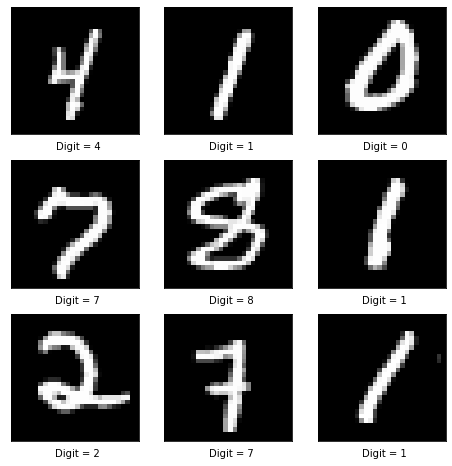

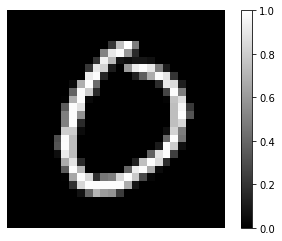

 - Print one test set image:


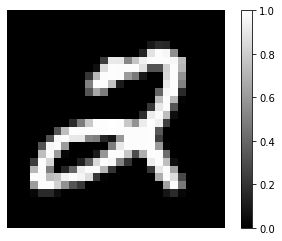

 - Print one test set label:
2



Extracting MNIST_CORRUPTED/IDENTITY dataset...



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incomplete6SZURY/mnist_corrupted-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incomplete6SZURY/mnist_corrupted-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist_corrupted',
    version=1.0.0,
    description='MNISTCorrupted is a dataset generated by adding 15 corruptions to the test
images in the MNIST dataset. This dataset wraps the static, corrupted MNIST
test images uploaded by the original authors',
    homepage='https://github.com/google-research/mnist-c',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{mu2019mnist,
      title={MNIST-C: A Robustness Benchmark for Computer Vision},
      author={Mu, Norman and Gilmer, Justin},
      journal={arXiv preprint arXiv:1906.02337},
     

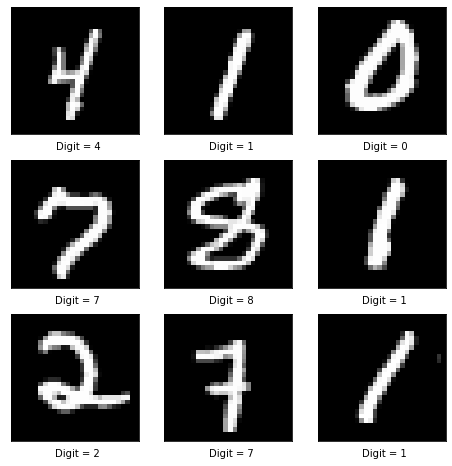

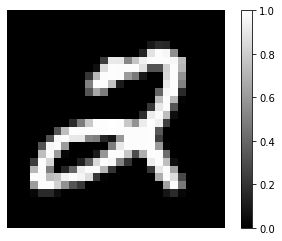

 - Print one test set label:
2




In [28]:
# Random seed is the microsecond for current time.
random_seed = datetime.now().microsecond

# Set the training and testing batch sizes.
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_TEST = 5000
# The number at which to split training sets and validation set, with training 
# set size = mnist_split, and validation = 60000 - mnist_split.
mnist_split = '55000' 

# List the different mnist data sets to use. The first should be the training
# dataset.
corrupted_names = ['identity', 'motion_blur', 'translate', 'rotate']
datasets_names = ['mnist'] + [
  f'mnist_corrupted/{corrupted_name}' for corrupted_name in corrupted_names
  ]

# Download the data sets.
datasets = get_datasets(
    datasets_names, 
    BATCH_SIZE_TRAIN, 
    BATCH_SIZE_TEST, 
    mnist_split, 
    random_seed
    )

# Drop 'mnist' from datasets_names.
datasets_names = datasets_names[1:]
# Select the first dataset as the training dataset.
training_datasets = [datasets_names[0].split('/')[0] + '/train/' + datasets_names[0].split('/')[1]]
testing_datasets = [name.split('/')[0] + '/test/' + name.split('/')[1] for name in datasets_names]
training_datasets = [datasets_names[0]]

# Get the list of keys from the datasets dict.
testing_datasets = list(datasets.keys())
# Drop 'mnist', so only the corrupted dataset names remain.
testing_datasets.remove('mnist')
# Create an empty dictionary to hold only the testing datasets.
testing_datasets_dict = dict()
# Loop through the corrupted dataset names.
for dataset in testing_datasets:
  # Add the corrupted data set to the new dictionary.
  testing_datasets_dict[dataset] = datasets[dataset]


# Set Hyperparameters

In [29]:
check_gpu_availibility()

SUCCESS: Found GPU: /device:GPU:0


In [30]:
###
# VAE Initializing Parameters
###

# Latent dim, set the dimensionality of the latent space.
z_dim_vals = [4]#[2, 4, 8, 16]
# Whether to use the analytical coupled divergence, or approximate.
analytic_kl = True
# Set the weight to place on the coupled dsivergence.
beta = 1.
# Set the standard deviation of the prior distribution.
p_std = 1.
# Set the loss coupling.
loss_coupling_vals = [0.0]#[0.0, 0.025, 0.05, 0.075]
# Set the number of base filters in the CNN.
n_filter_base = 64
# Set the learning rate for the Adam optimizer.
learning_rate = 0.0005


###
# VAE Training Parameters
###

# Set the number of epochs to display.
n_epoch = 100
# Set the number of epochs before plots are displayed.
n_epoch_display = 1
# Whether or not to display plots while training.
show_display = False
display_sample = True


###
# Setting Paths
###

# Set the version of the code being ran.
version = 'v5'
# Create the root path where the data will be stored.
#save_path = Path(
#    f'gdrive/My Drive/Colab Notebooks/coupled_vae/vae/output/{version}/'
#    )
save_path = Path(
    f'gdrive/My Drive/Colab Notebooks/coupled_vae/output/{version}/'
    )
# If the path does not exist, make it.
save_path.mkdir(parents=True, exist_ok=True)

# Set the dirctory to the model and make it if it does not exist.
model_directory = 'mnist/'
model_path = save_path / str(random_seed) / model_directory
model_path.mkdir(parents=True, exist_ok=True)

# Create the folders for this run in the google drive. It will not override 
# existing version and seed folders
create_gdrive_output_folders(model_path)

# Save the parameters in a dict.
param_dict = {
  'random_seed': random_seed,
  'z_dim_vals': z_dim_vals,
  'analytic_kl': analytic_kl,
  'beta': beta,
  'p_std': p_std,
  'loss_coupling_vals': loss_coupling_vals,
  'n_filter_base': n_filter_base,
  'learning_rate': learning_rate,
  'n_epoch': n_epoch,
  'n_epoch_display': n_epoch_display,
  'train_batch_size': BATCH_SIZE_TRAIN,
  'test_batch_size': BATCH_SIZE_TEST,
  'val_split': mnist_split,
  'datasets': datasets_names,
  'show_display': show_display,
  'display_sample': show_display,
  'model_path': model_path
}

# Set the path for the experiment tracking CSV file.
experiment_tracker_path = save_path / 'experiment_tracker.csv'
# Update the file.
update_experiments(param_dict, experiment_tracker_path)

# Set the training and testing paths.
training_path = model_path / 'train'
testing_path = model_path / 'test'

Reading [gdrive/My Drive/Colab Notebooks/coupled_vae/output/v5/experiment_tracker.csv]
Updating [gdrive/My Drive/Colab Notebooks/coupled_vae/output/v5/experiment_tracker.csv]
Writing [gdrive/My Drive/Colab Notebooks/coupled_vae/output/v5/experiment_tracker.csv]


# Train VAE

Epoch: 3, Train set Loss: 144.36566612153808,
 Train set Recon: 130.12302181434188, Train set KL: 14.242644307196171, 
Val set Loss: 143.68580001369025,
 Val set Recon: 128.9210313192935, Val set KL: 14.764768694396759, 
time elapse for current epoch: 39.552536964416504
Saving model checkpoint at epoch 3
gdrive/My Drive/Colab Notebooks/coupled_vae/output/v5/957071/mnist/train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


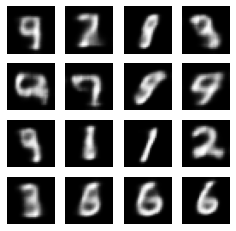

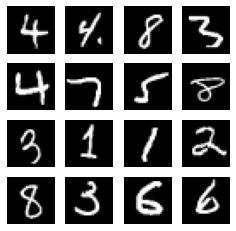

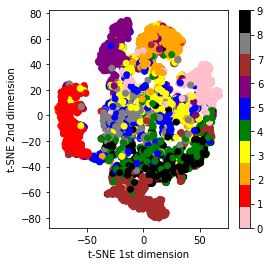

/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:398: RuntimeWarning: invalid value encountered in double_scalars
  return points[1, 0] - points[0, 0]


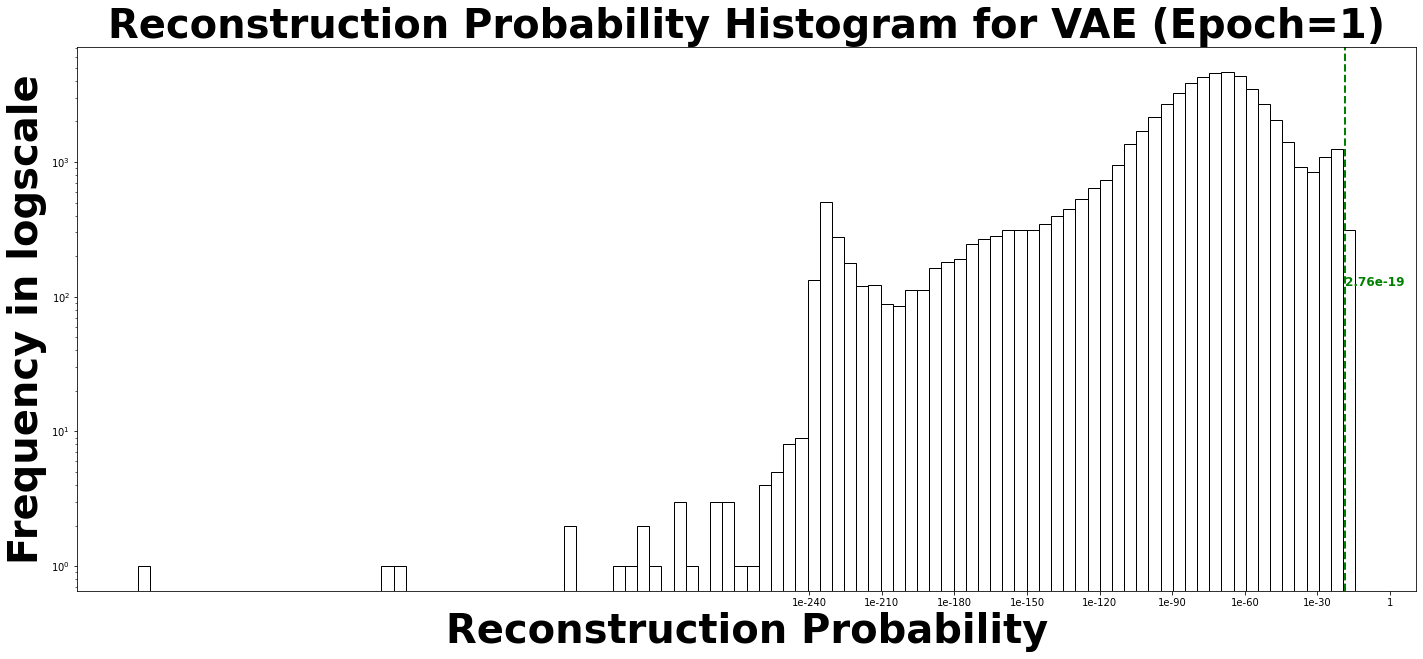

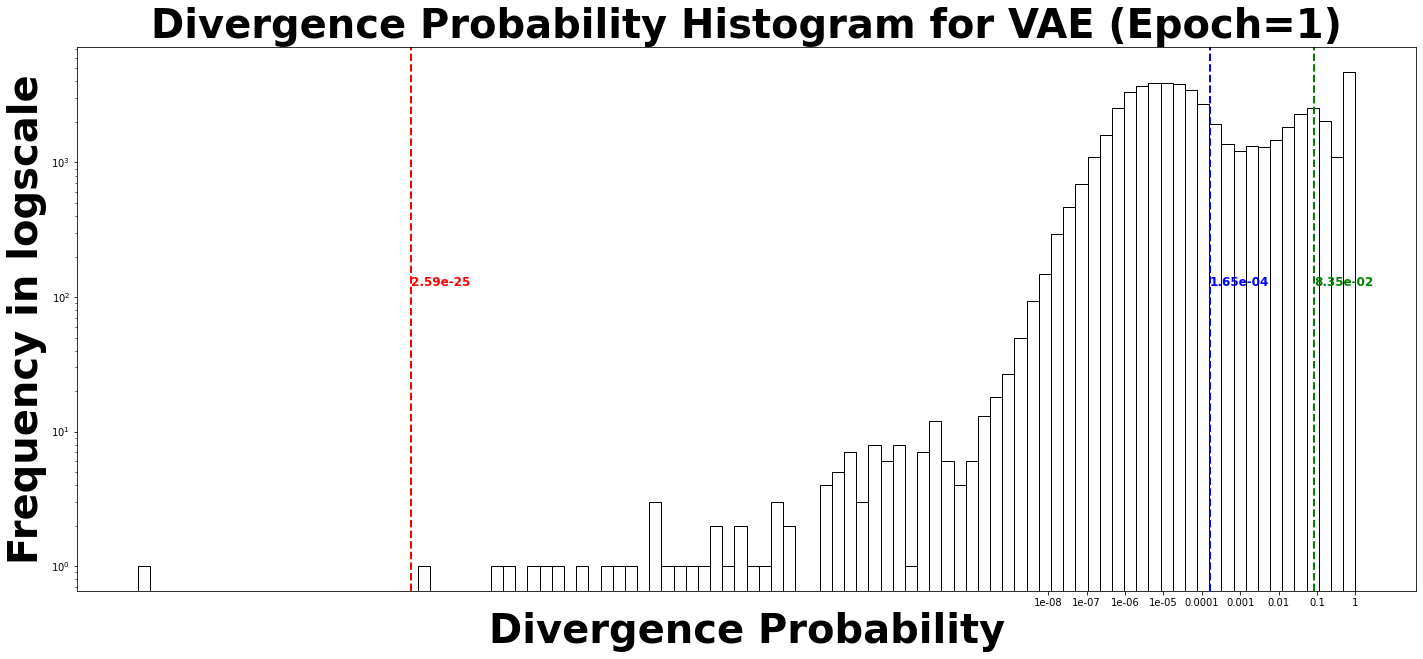

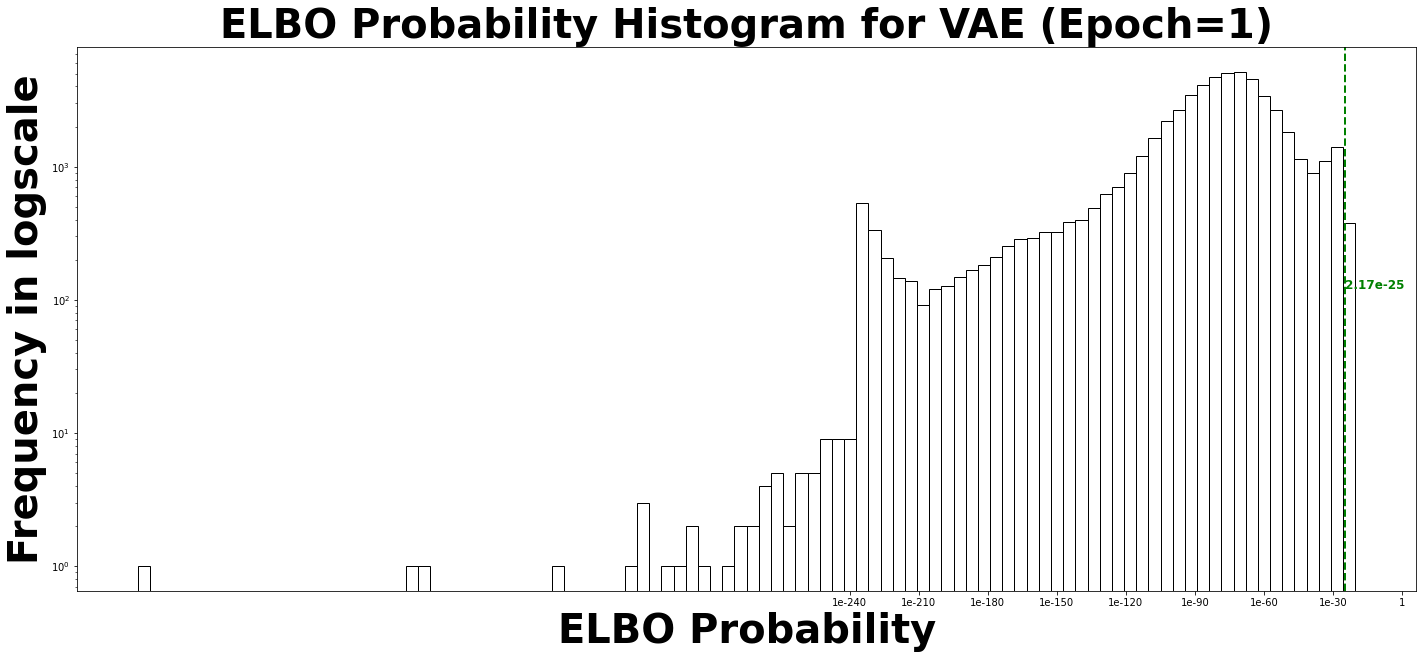

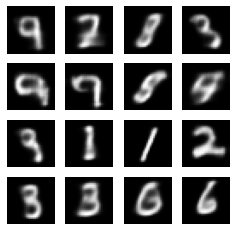

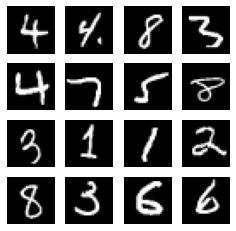

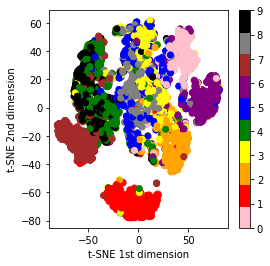

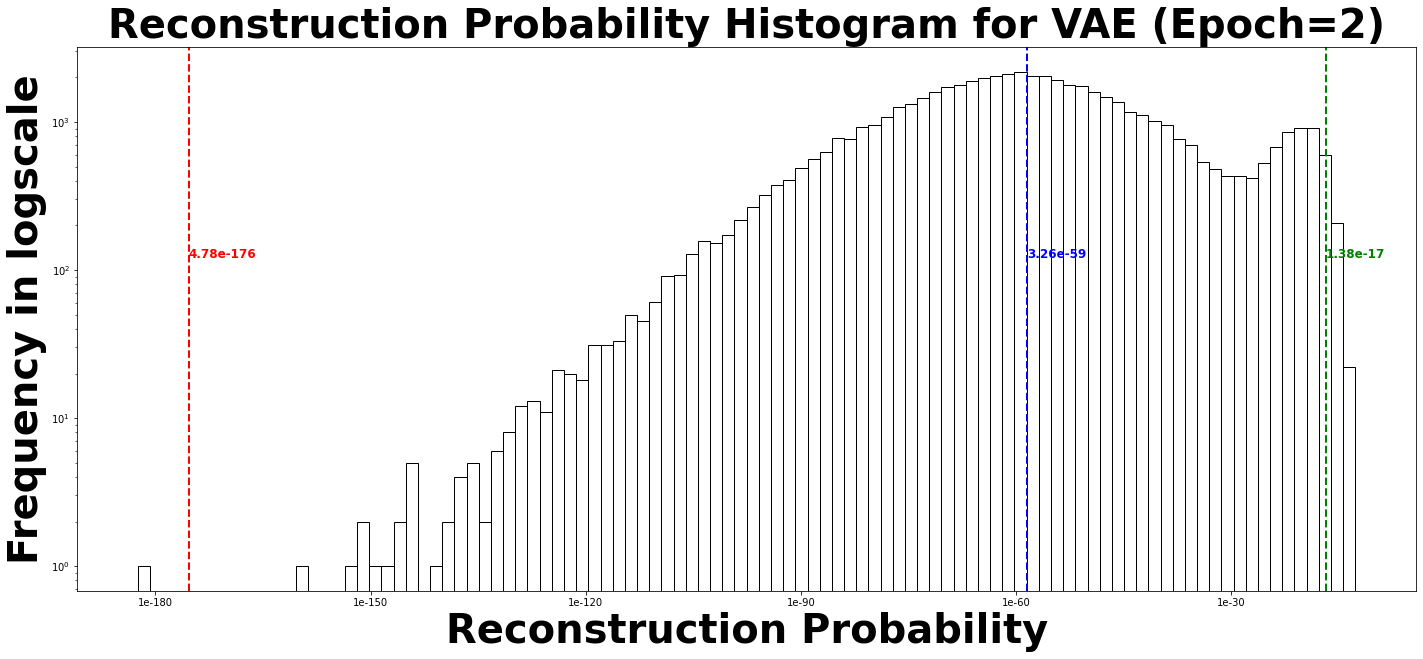

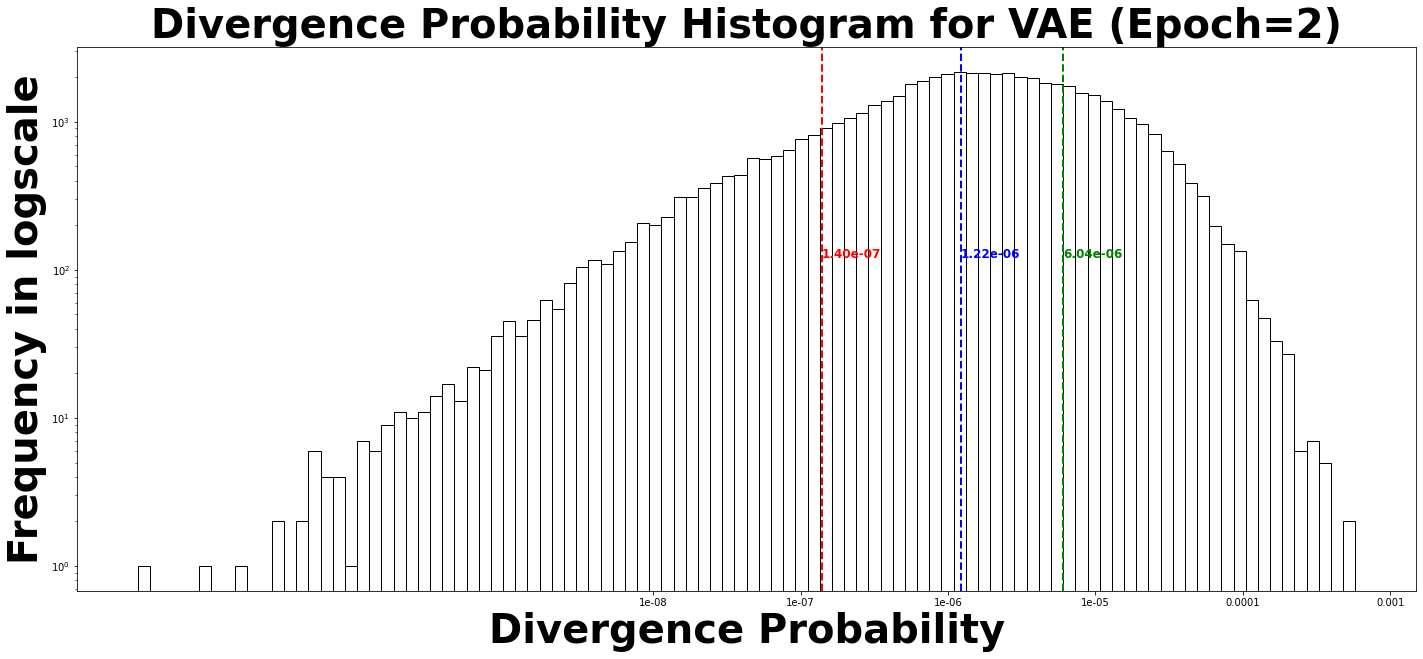

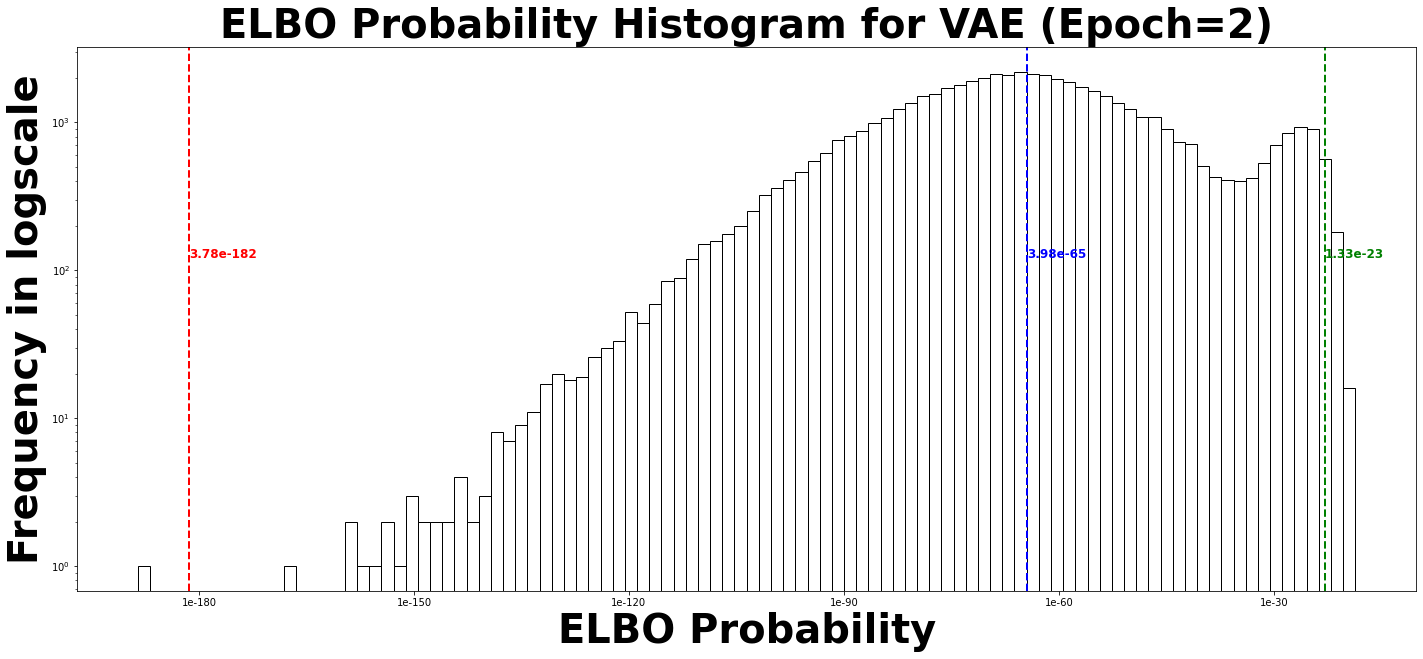

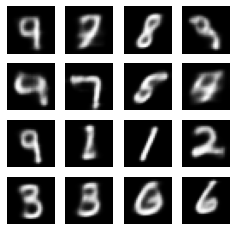

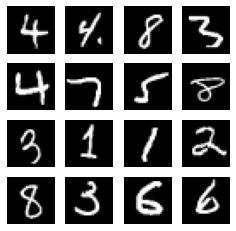

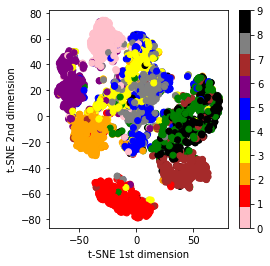

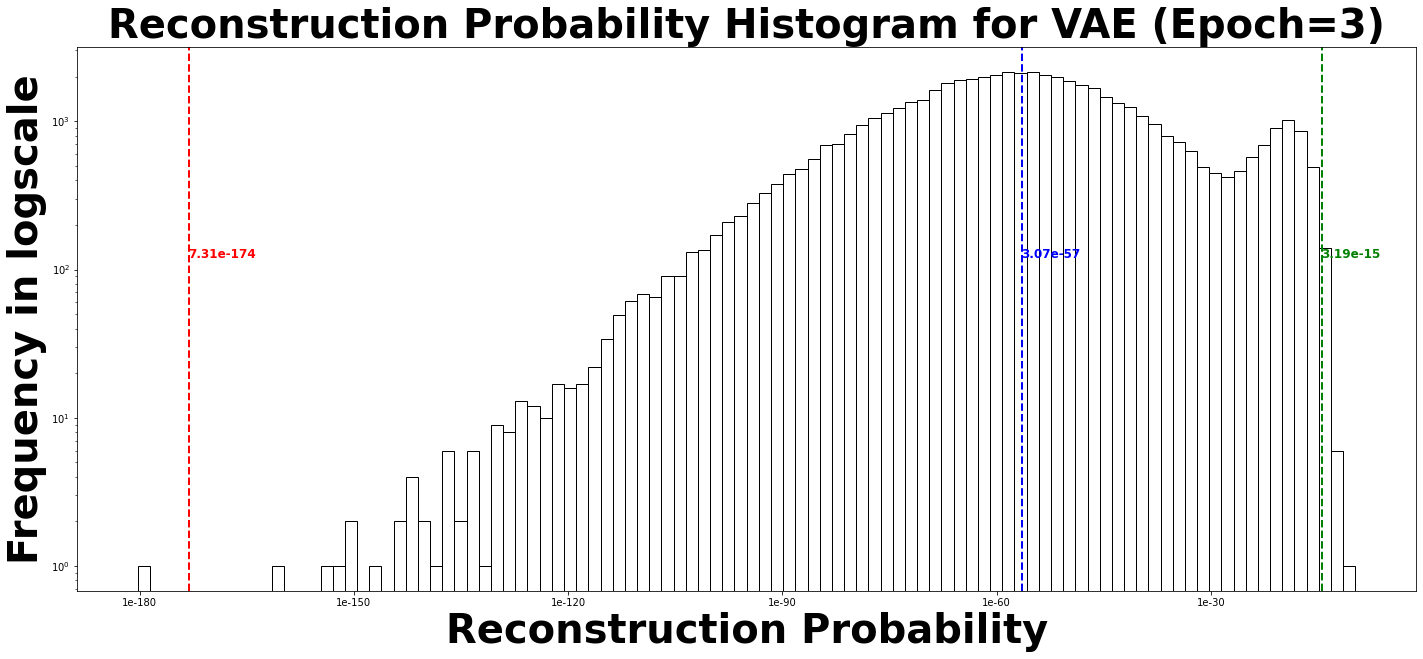

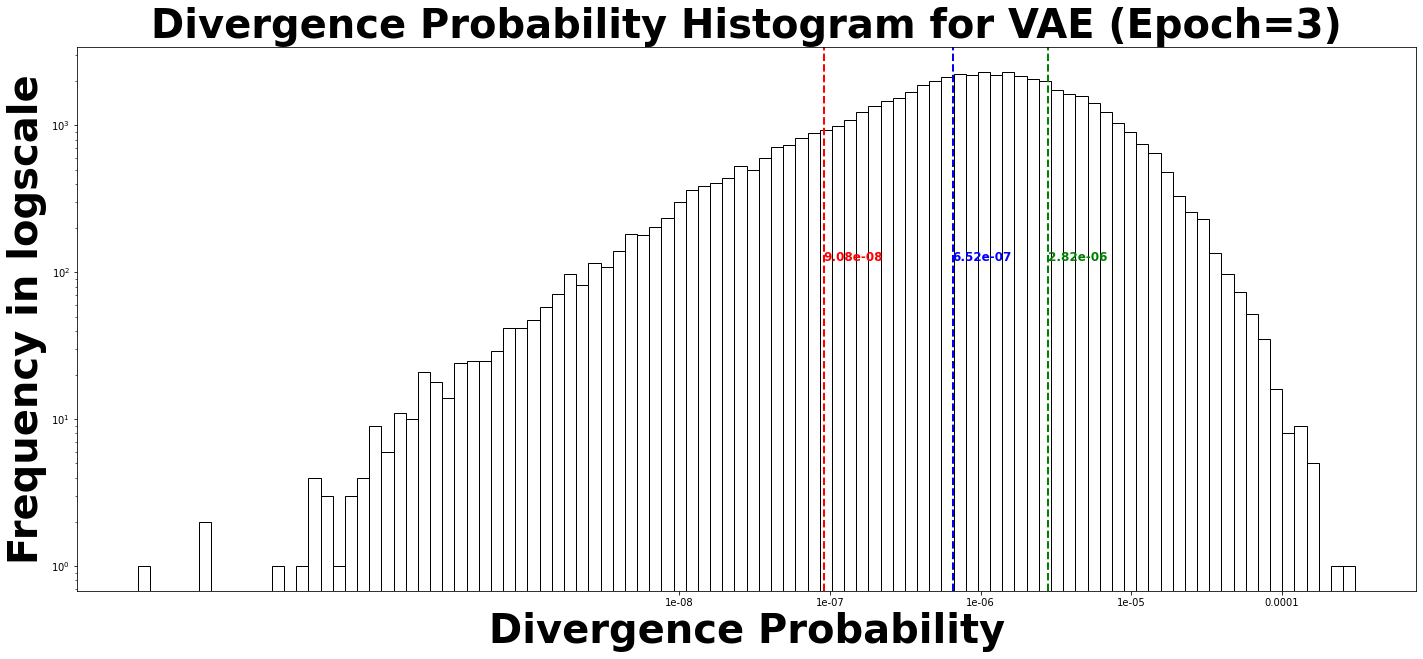

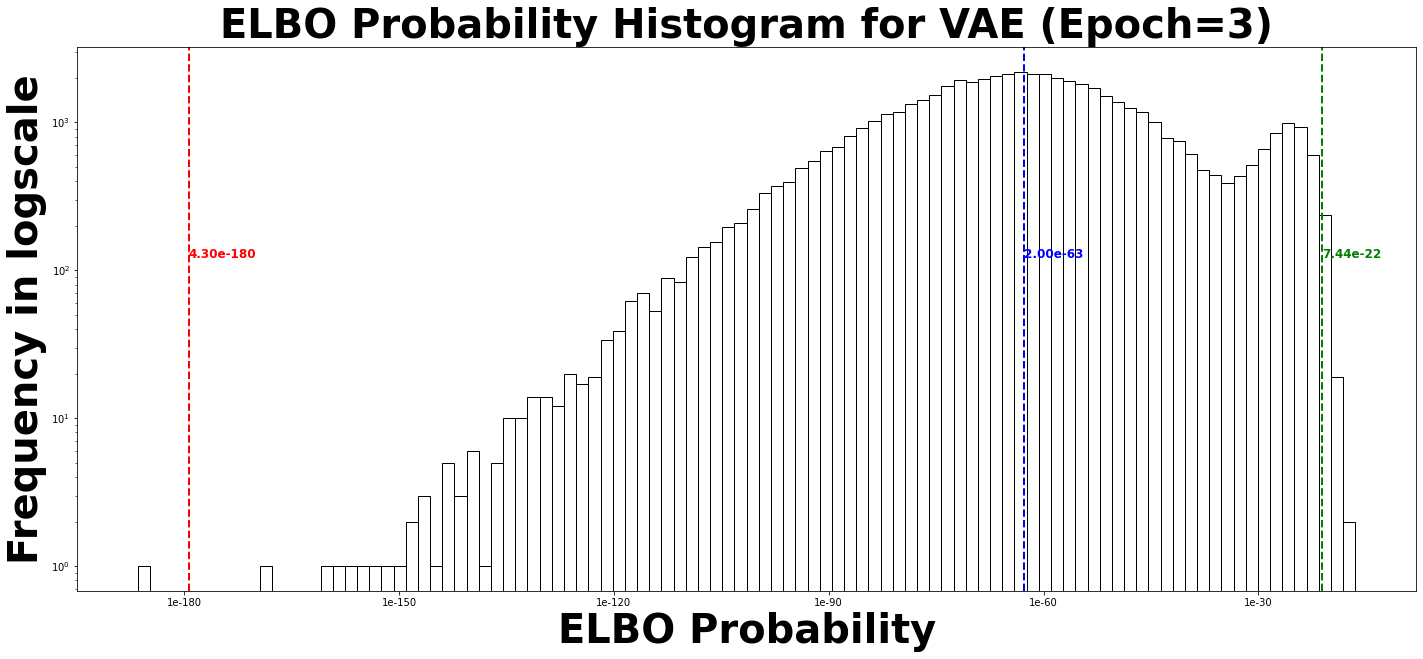

In [31]:
early_stop = 3
vae_dict = train_VAEs(
    loss_coupling_vals, 
    z_dim_vals, 
    beta,
    p_std, 
    analytic_kl, 
    n_epoch,
    n_epoch_display, 
    datasets,
    training_datasets,
    random_seed, 
    training_path,
    show_display=show_display,
    early_stop=early_stop
    )

# Plot

In [32]:
# Plot the latent space.
if z_dim_vals == [2]:
  for vae_key in vae_dict.keys():
    print(f'Latent Space for {vae_key}')
    plot_latent_images(vae_dict[vae_key].model, n=15, digit_size=28)

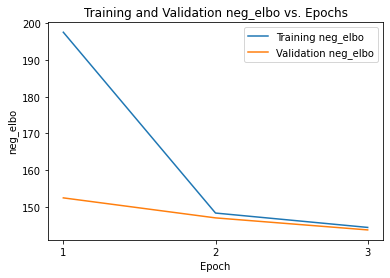

In [33]:
plot_training(vae_dict, metric='neg_elbo')

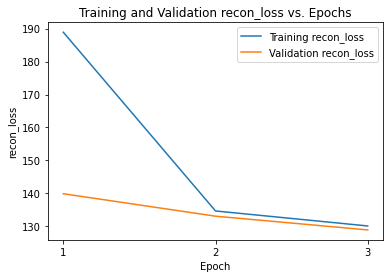

In [34]:
plot_training(vae_dict, metric='recon_loss')

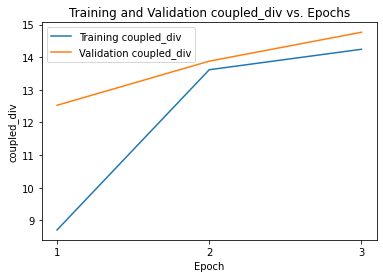

In [35]:
plot_training(vae_dict, metric='coupled_div')

In [36]:
best_model_epoch = vae_dict['identity'].val_metrics_df.loc[
                                        vae_dict['identity'].val_metrics_df['val_neg_elbo'] 
                                        == vae_dict['identity'].val_metrics_df['val_neg_elbo'].min()
                                        ].index.values + 1

print(f'The best model was saved at epoch {best_model_epoch[0]}.')

The best model was saved at epoch 3.


# Test

In [37]:
vae = vae_dict['identity']

# Load the best model by validation set performance from the checkpoints.
vae.model.load_weights(str(model_path) + '/train/cp.ckpt')

In [38]:
# Get the list of keys from the datasets dict.
testing_datasets = list(datasets.keys())
# Drop 'mnist', so only the corrupted dataset names remain.
testing_datasets.remove('mnist')
# Create an empty dictionary to hold only the testing datasets.
testing_datasets_dict = dict()
# Loop through the corrupted dataset names.
for dataset in testing_datasets:
  # Add the corrupted data set to the new dictionary.
  testing_datasets_dict[dataset] = datasets[dataset]

Test set Loss: 143.07708989873313, Test set Recon: 128.33233379401926, Test set KL: 14.744756104713865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


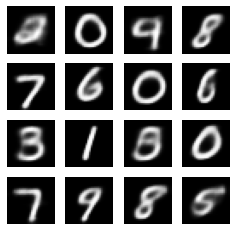

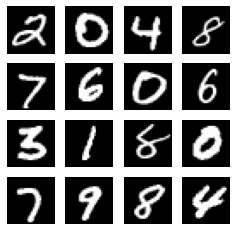

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


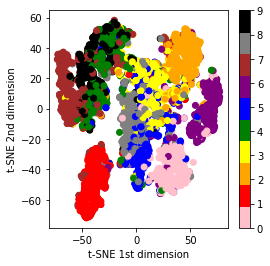

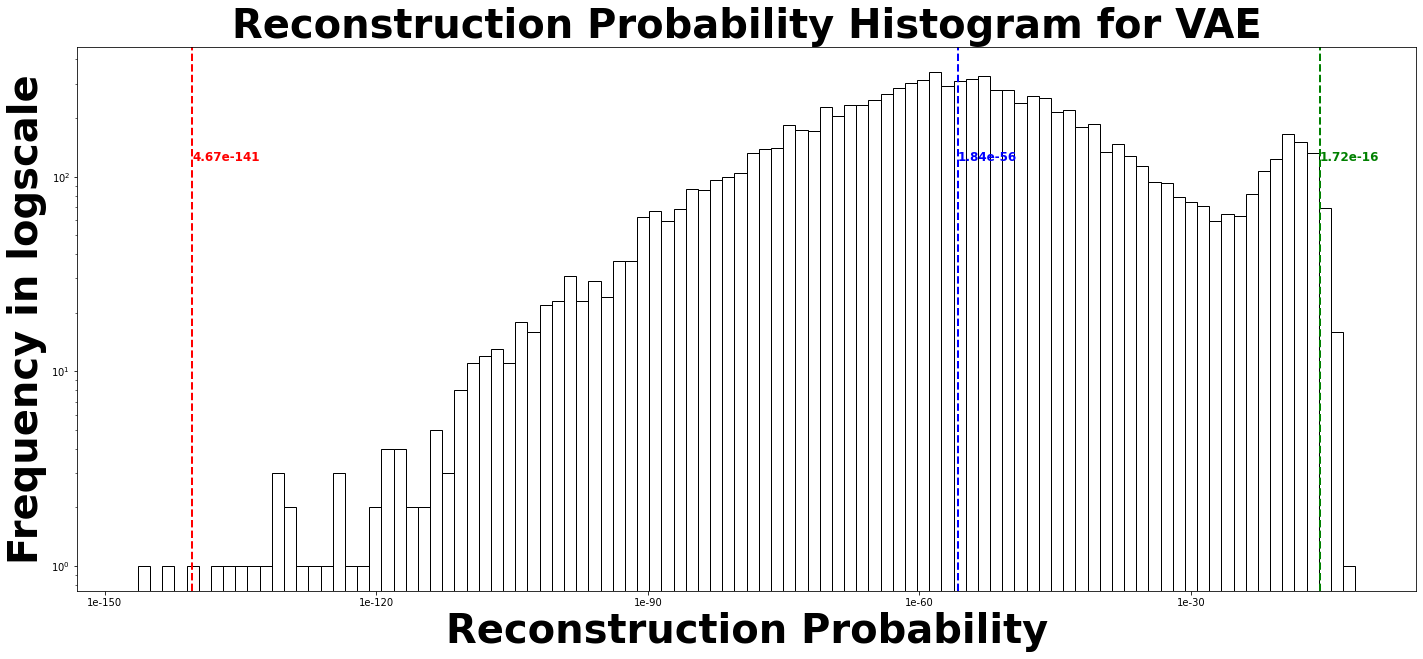

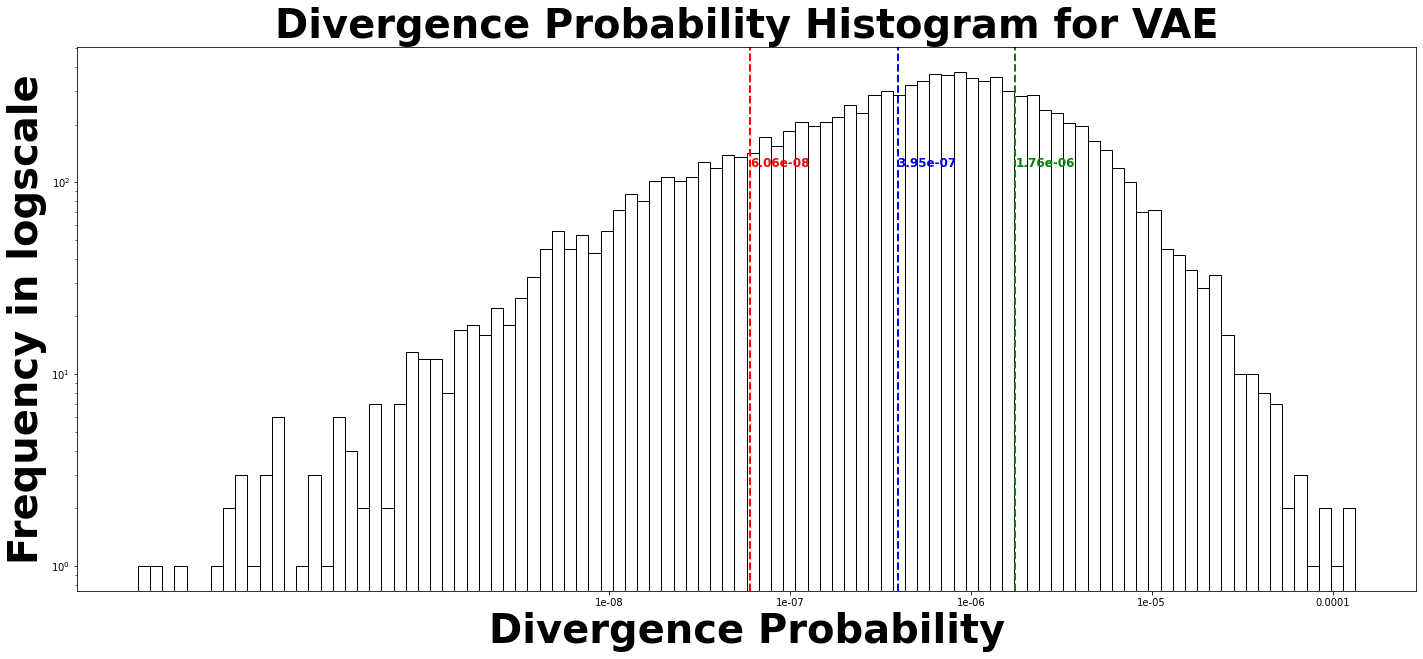

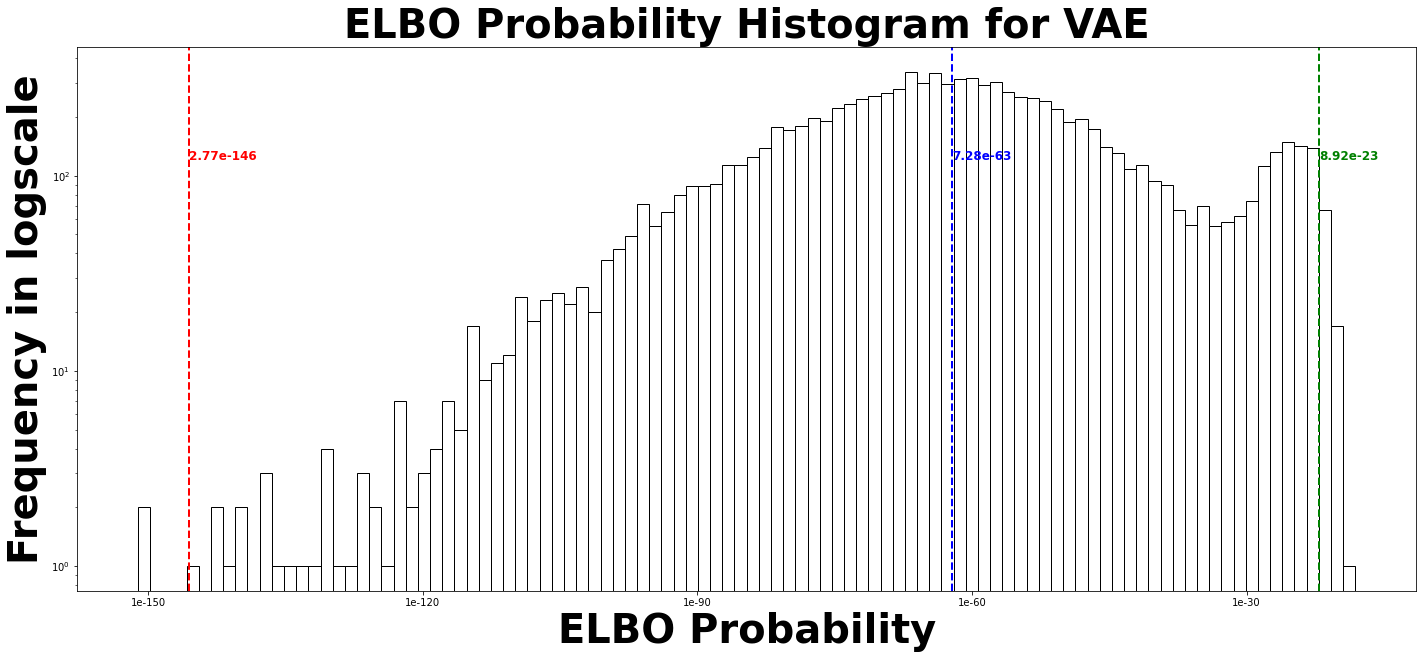

Writing gdrive/My Drive/Colab Notebooks/coupled_vae/output/v5/957071/mnist/test/identity/metrics/table__beta1.0_zdim4_p_std1.0_coupling0.0_seed957071.csv


In [39]:
test_VAE_loop(
    my_vae=vae,
    datasets=testing_datasets_dict, 
    test_path=testing_path, 
    show_display=True,
    random_seed=random_seed
    )